## 🔧 Setup

In [82]:
import os
import time
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langchain_groq import ChatGroq
from bs4 import BeautifulSoup
from urllib.parse import urljoin

nltk.download('vader_lexicon')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

os.environ['GROQ_API_KEY'] = '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'
marketstack_api_key = '694d1250c8ae084e4046d6dc6fbf5f81'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 📰 Article Scraper

In [92]:
def get_articles():
    article_title = []
    article_urls = []
    url = "https://www.cnbctv18.com/market/stocks/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all('a', class_='jsx-95506e352219bddb story-media')
    for article in articles:
        try:
            title = article['title'].strip()
            link = urljoin(url, article['href'])
            article_title.append(title)
            article_urls.append(link)
        except:
            continue
    return article_title, article_urls


## 📈 Marketstack Fetcher

In [93]:
def get_marketstack_data(symbol, api_key, start_date, end_date):
    url = "http://api.marketstack.com/v1/eod"
    params = {
        'access_key': api_key,
        'symbols': symbol,
        'date_from': start_date,
        'date_to': end_date,
        'limit': 1000
    }

    response = requests.get(url, params=params)
    try:
        data = response.json()
    except ValueError:
        print(f"❌ JSON Error for {symbol}: {response.text[:200]}")
        return pd.DataFrame()

    if 'data' not in data or not data['data']:
        
        return pd.DataFrame()

    df = pd.DataFrame(data['data'])
    df['date'] = pd.to_datetime(df['date'])
    df.rename(columns={
        'date': 'Date',
        'open': 'Open',
        'close': 'Close',
        'high': 'High',
        'low': 'Low',
        'volume': 'Volume'
    }, inplace=True)
    return df[['Date', 'Open', 'Close', 'High', 'Low', 'Volume']]










In [ ]:
def get_stock_data(symbol, start_date, end_date):
    # First try MarketStack
    df = get_marketstack_data(symbol, marketstack_api_key, start_date, end_date)


# append XNSE
    if df.empty:
        symbol=symbol+".XNSE"
        df = get_marketstack_data(symbol, marketstack_api_key, start_date, end_date)
        
    return df

   

## 🔮 Forecasting Function

In [ ]:
def forecast_stock(symbol):
    start_date = "2015-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")
    
    print(f"\n📈 Forecasting for: {symbol}")
    df = get_stock_data(symbol, start_date, end_date)


    if df.empty:
        print(f"⚠️ No historical data found for {symbol}. Skipping.")
        return
    
    if len(df) < 100:
        print(f"⚠️ Not enough data points for {symbol} ({len(df)} rows). Skipping.")
        return

    try:
        # Feature engineering
        df.sort_values('Date', inplace=True)
        df['MA_20'] = df['Close'].rolling(20).mean()
        for i in range(1, 8):
            df[f"Close_lag_{i}"] = df['Close'].shift(i)
        df.dropna(inplace=True)

        # Prepare for Prophet
        df['ds'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
        df = df.rename(columns={'Close': 'y'})

        model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
        model.add_regressor('Volume')
        model.add_regressor('MA_20')
        for i in range(1, 8):
            model.add_regressor(f"Close_lag_{i}")
        model.fit(df)

        future = df.tail(30).copy()
        forecast = model.predict(future)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(df['ds'], df['y'], label='Actual', linewidth=2)
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linewidth=2)
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
        plt.title(f"{symbol} - 30-Day Forecast vs Actual ({df['ds'].min().date()} → {df['ds'].max().date()})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        

    except Exception as e:
        print(f"❌ Forecasting failed for {symbol}: {e}")


## 🤖 Analyze Article

In [96]:
def analyze_article(url, symbols_df):
    import re
    from langchain.document_loaders import UnstructuredURLLoader
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from difflib import get_close_matches

    loader = UnstructuredURLLoader(urls=[url])
    data = loader.load()

    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = splitter.split_documents(data)
    docs = [doc for doc in docs if len(doc.page_content.strip()) > 100]
    text = docs[0].page_content[:1000] if docs else ""

    llm = ChatGroq(model="llama3-8b-8192", temperature=0.7, max_tokens=512)
    
    # Summarize and get sentiment
    summary = llm.invoke(f"Summarize this article:\n{text}").content
    sentiment = 'negative' if analyzer.polarity_scores(summary)['compound'] < 0 else 'positive'

    # Get company names from LLM instead of SpaCy NER
    company_prompt = f"List publicly traded companies mentioned in this article:\n{text}"
    companies_text = llm.invoke(company_prompt).content
    raw_names = [line.strip().upper() for line in companies_text.split('\n') if line.strip()]

    # Clean names
    cleaned_names = []
    for name in raw_names:
        name = re.sub(r'[^A-Z &]', '', name)  # remove numbers, punctuation
        name = name.strip()
        if len(name) > 3:
            cleaned_names.append(name)

    stock_names = list(set(cleaned_names))

    # Generate variations
    variations = []
    for name in stock_names:
        if '&' in name:
            variations.append(name.replace('&', 'AND'))
        elif 'AND' in name:
            variations.append(name.replace('AND', '&'))
        if 'LTD' in name:
            variations.append(name.replace('LTD', 'LIMITED'))
        elif 'LIMITED' in name:
            variations.append(name.replace('LIMITED', 'LTD'))
    stock_names.extend(variations)
    stock_names = list(set(stock_names))

    # Match to symbols
    symbols_df['Name'] = symbols_df['Name'].str.upper()
    matched = []

    for name in stock_names:
        exact = symbols_df[symbols_df['Name'] == name]['Symbol'].tolist()
        if exact:
            matched.extend(exact)
        else:
            try:
                partial = symbols_df[symbols_df['Name'].str.contains(re.escape(name), na=False, regex=True)]['Symbol'].tolist()
                if partial:
                    matched.extend(partial)
                else:
                    close_names = get_close_matches(name, symbols_df['Name'], n=1, cutoff=0.85)
                    if close_names:
                        symbol = symbols_df[symbols_df['Name'] == close_names[0]]['Symbol'].values[0]
                        matched.append(symbol)
            except Exception as e:
                print(f"Regex error for name: {name} → {e}")

    matched = list(set(matched))  # Remove duplicates

    if not matched:
        print(f"⚠️ No symbols matched for these names: {stock_names}")

    return summary, sentiment, stock_names, matched


## 🚀 Run Pipeline


Processing article: Stocks to Watch on March 28: Jio Financial Services, Force Motors, HAL, JSPL and more
https://www.cnbctv18.com/photos/market/stocks/stocks-to-watch-on-march-28-jio-financial-services-force-motors-hal-jspl-and-more-19580696.htm
Summary: The article lists the stocks to watch for March 28, 2023. The following companies are expected to be in focus:

1. Jio Financial Services
2. Force Motors
3. JSPL (Jindal Steel and Power Limited)
4. Asian Paints
5. HAL (Hindustan Aeronautics Limited)
6. HCLTech
7. Infosys

No further information is provided about the reasons behind these stocks being in focus or any specific news or events that may be driving their prices.
Sentiment: negative
Companies: ['INFOSYS', 'JSPL JINDAL STEEL & POWER LIMITED', 'HAL HINDUSTAN AERONAUTICS LIMITED', 'JIO FINANCIAL SERVICES', 'JSPL JINDAL STEEL AND POWER LIMITED', 'JSPL JINDAL STEEL AND POWER LTD', 'HERE ARE THE PUBLICLY TRADED COMPANIES MENTIONED IN THE ARTICLE', 'HCLTECH', 'HAL HINDUSTAN AERONAU

23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing


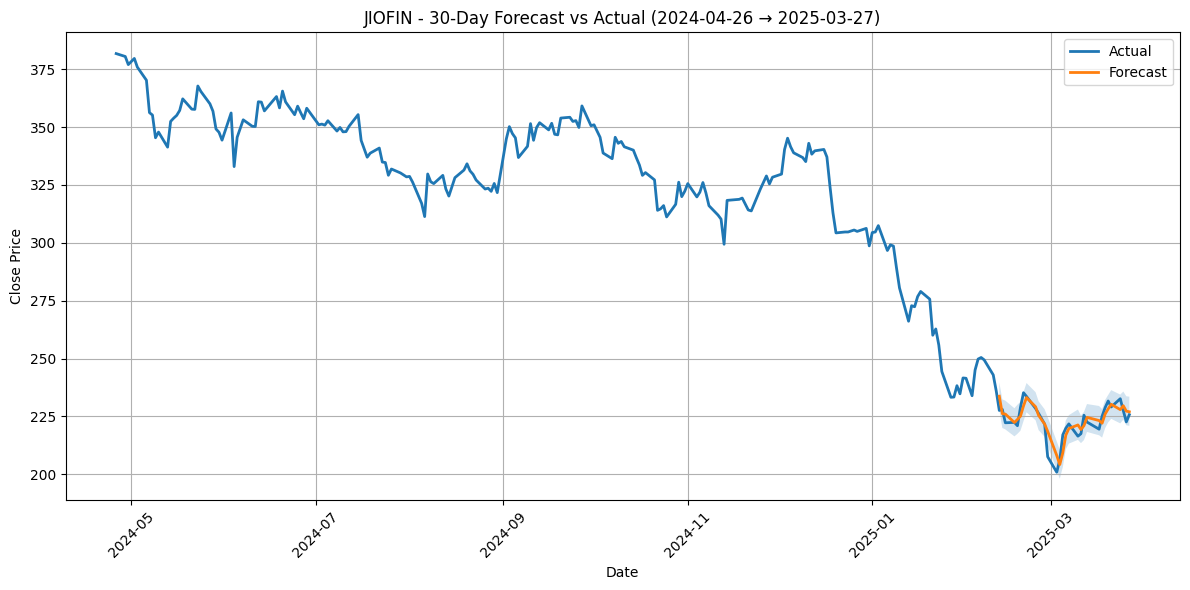


Forecasting for: HAL

📈 Forecasting for: HAL


23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing


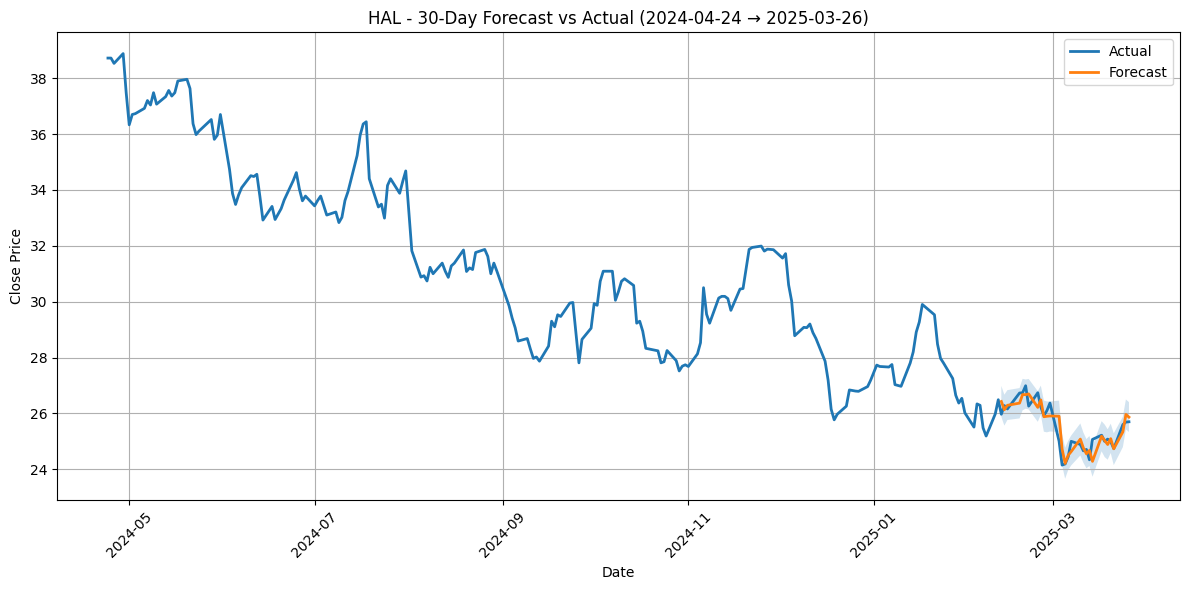


Forecasting for: JINDALSTEL

📈 Forecasting for: JINDALSTEL


23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing


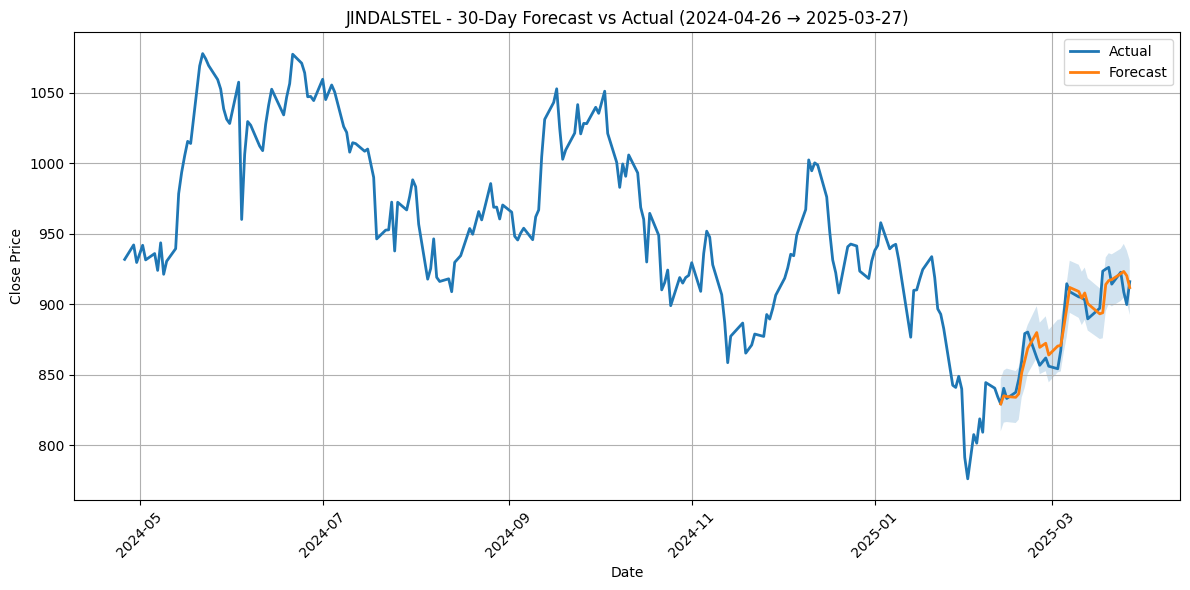


Forecasting for: INFY

📈 Forecasting for: INFY


23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing


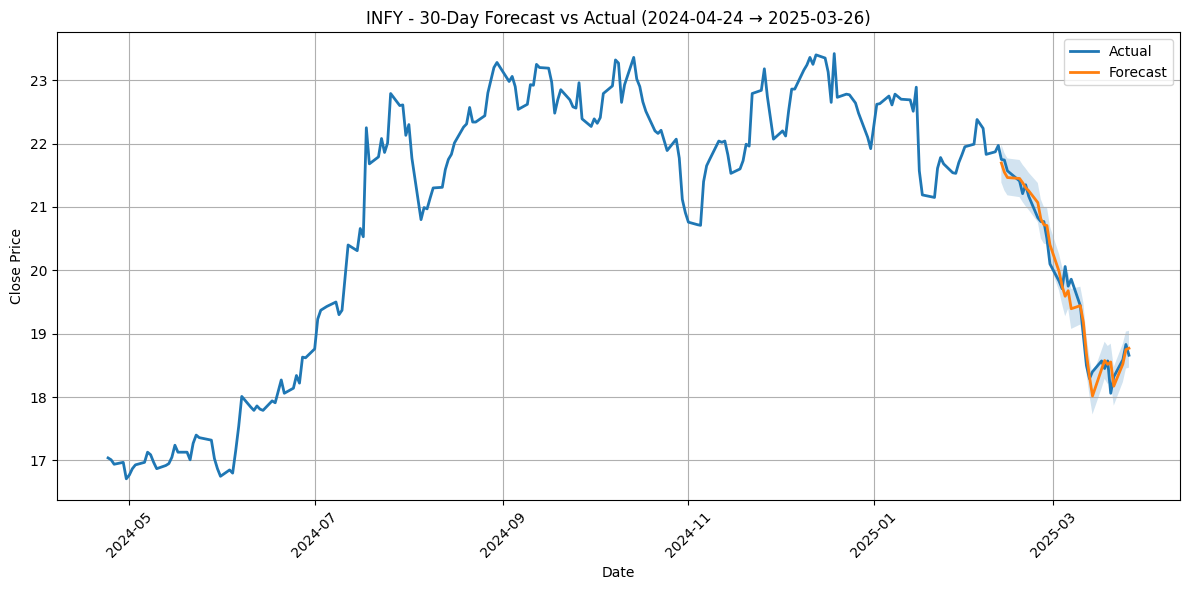


Forecasting for: HCL-INSYS

📈 Forecasting for: HCL-INSYS


23:40:15 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing


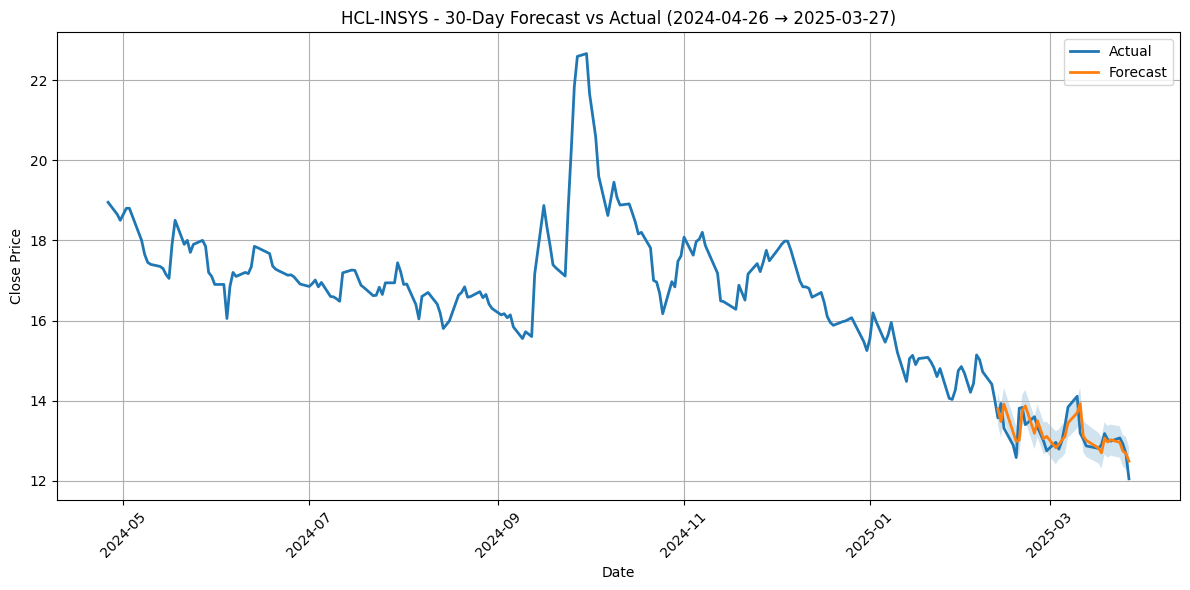


Forecasting for: ASIANPAINT

📈 Forecasting for: ASIANPAINT


23:40:37 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing


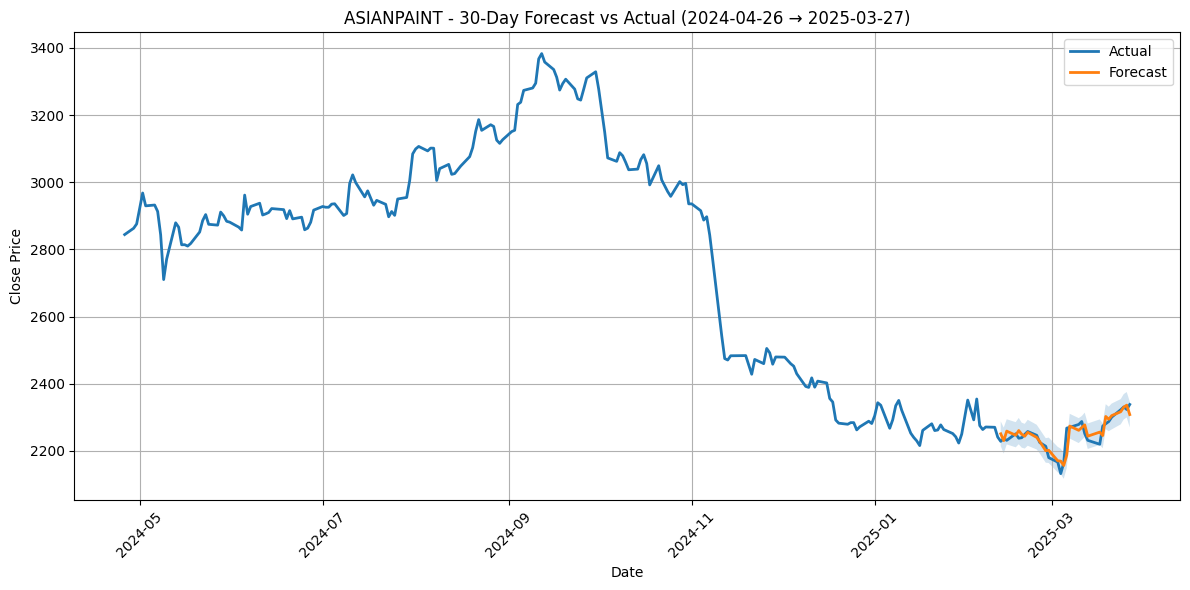


Forecasting for: FORCEMOT

📈 Forecasting for: FORCEMOT


23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:00 - cmdstanpy - INFO - Chain [1] done processing


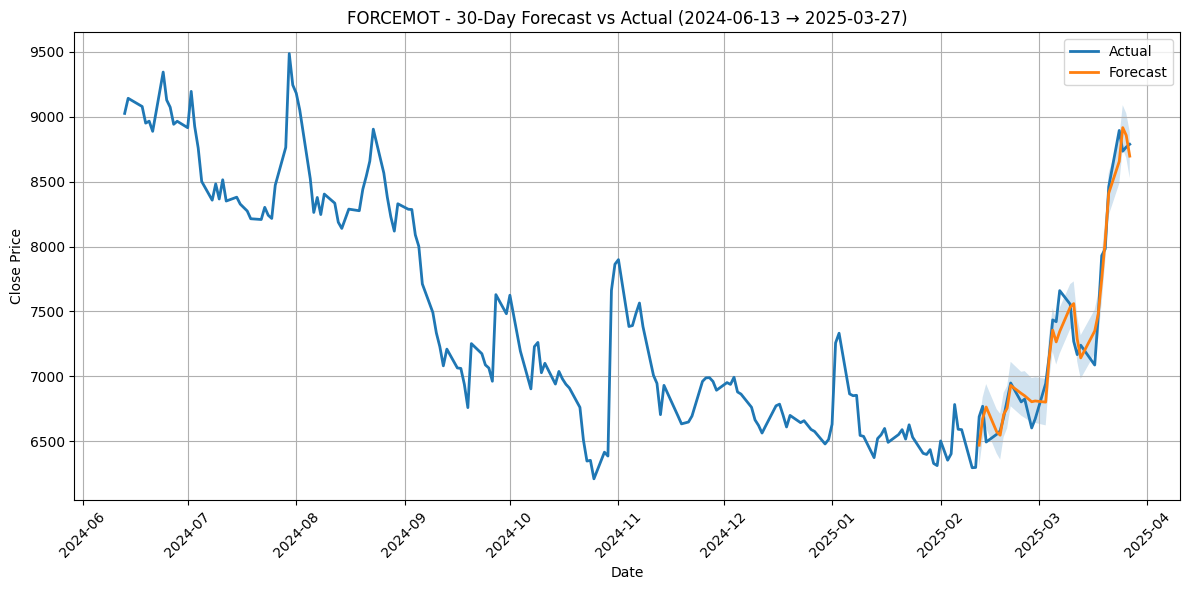


Processing article: March heat boosts Varun Beverages; consumer & retail sectors face mixed trends, says Nuvama
https://www.cnbctv18.com/market/march-heat-varun-beverages-consumer-retail-sectors-impact-trends-nuvama-19580463.htm
Summary: The article discusses the performance of various consumer goods companies in India, particularly in the context of the March quarter. According to Abneesh Roy, Executive Director of Nuvama Institutional Equities, some companies are facing mixed trends.

Varun Beverages, a beverage company, has seen a boost in March due to increased demand. On the other hand, Hindustan Unilever (HUL) and Colgate are struggling with weak volume growth due to rising costs of raw materials, such as tea, palm oil, and copra, as well as competition from Dabur in the oral care market.
Sentiment: positive
Companies: ['HINDUSTAN UNILEVER LTD HUL', 'COLGATE', 'HERE ARE THE PUBLICLY TRADED COMPANIES MENTIONED IN THE ARTICLE', 'DABUR', 'HINDUSTAN UNILEVER LIMITED HUL', 'VARUN BEV

23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing


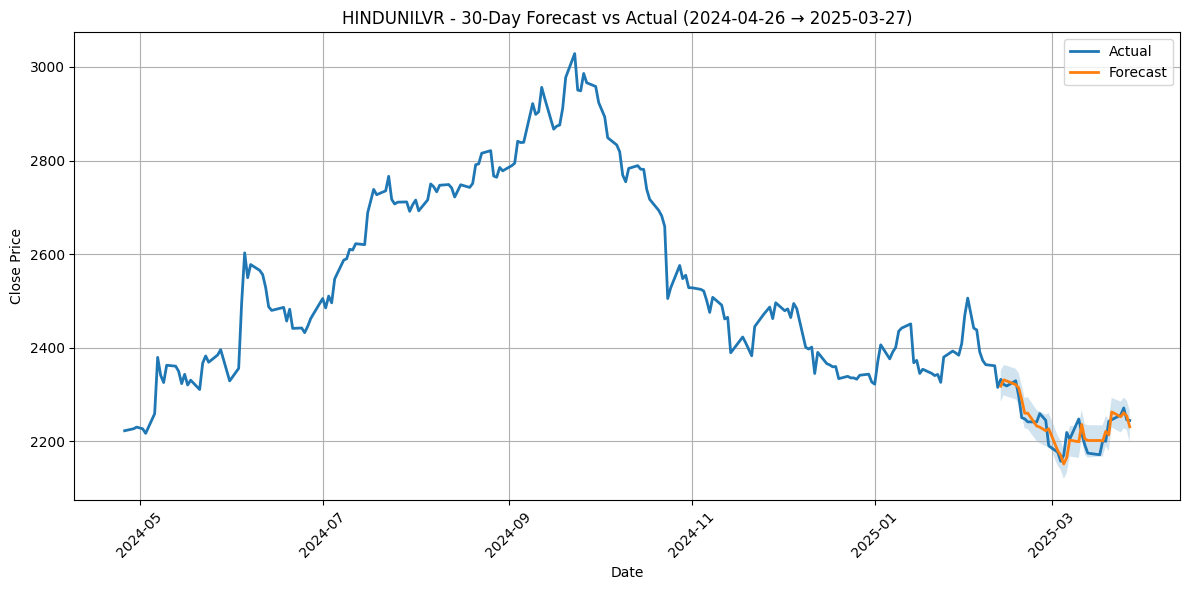


Forecasting for: VBL

📈 Forecasting for: VBL


23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:03 - cmdstanpy - INFO - Chain [1] done processing


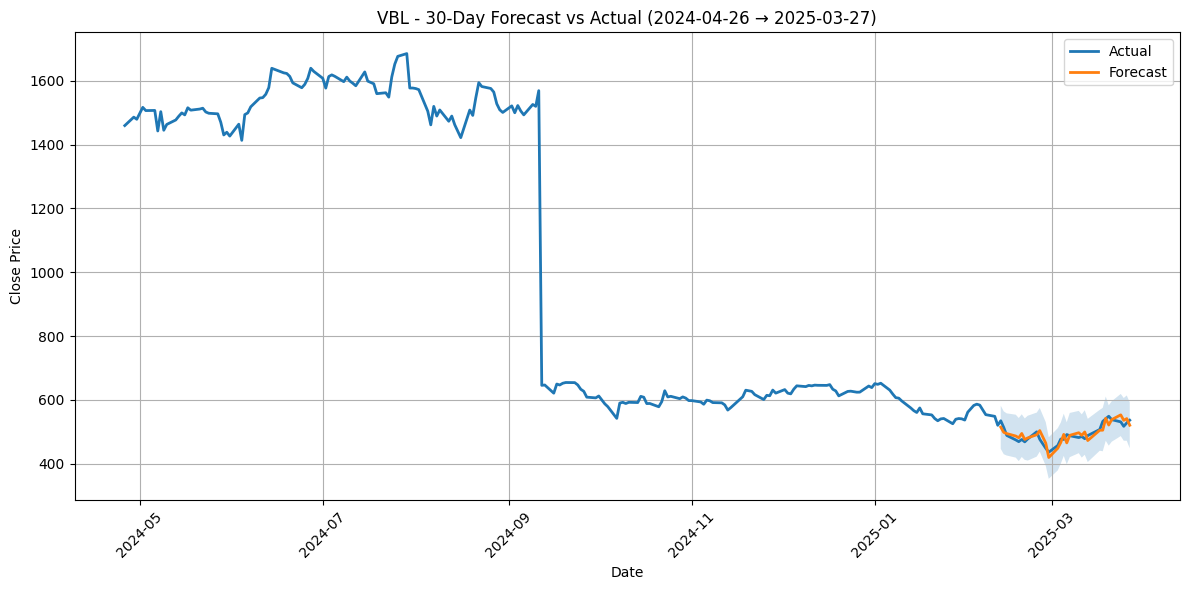


Forecasting for: DABUR

📈 Forecasting for: DABUR


23:42:23 - cmdstanpy - INFO - Chain [1] start processing
23:42:24 - cmdstanpy - INFO - Chain [1] done processing


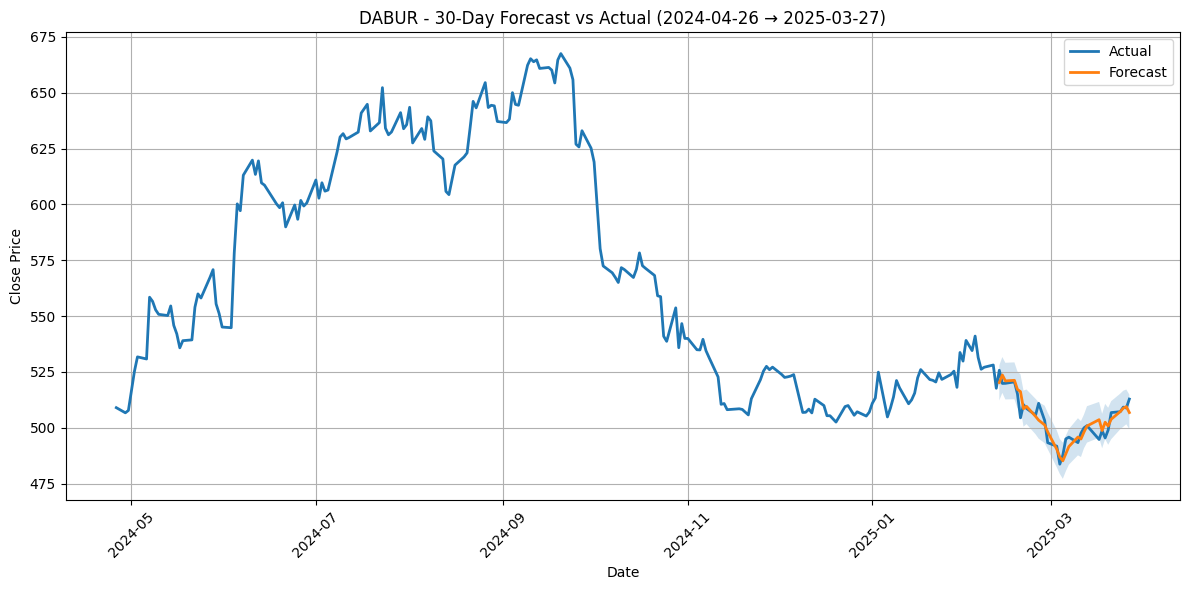

KeyboardInterrupt: 

In [97]:
symbols_df = pd.read_csv('merged_cleaned stock&symbols.csv')[['Name', 'Symbol']]
symbols_df = symbols_df.dropna(subset=["Symbol"])
symbols_df = symbols_df[symbols_df["Symbol"] != "#REF!"]

titles, urls = get_articles()
for title, url in zip(titles, urls[:3]):
    print(f"\nProcessing article: {title}\n{url}")
    try:
        summary, sentiment, stock_names, matched_symbols = analyze_article(url, symbols_df)
        print(f"Summary: {summary}")
        print(f"Sentiment: {sentiment}")
        print(f"Companies: {stock_names}")
        print(f"Symbols: {matched_symbols}")

        for symbol in matched_symbols:
            print(f"\nForecasting for: {symbol}")
            forecast_stock(symbol)
            time.sleep(15)
    except Exception as e:
        print(f"Error processing article: {e}")
